# Problem 7
## PSF deconvolution with Neural Networks
- Contacts: Charles and Connor

## Problem description :
- Given a blurry astronomical image and the kernel (PSF) that blurred it, recover the original image in the presence of noise

## What's the main issue?
- Astronomical images are always blurred to some degree by a point spread function (PSF), which is the response of the telescope's imaging system to point sources. This obscures detail that might otherwise be astrophysically relevant. Optimal deconvolution is an unsolved problem.

## What is the potential solution to this problem?
- In the absence of noise, one can invert the blurring process in frequency space using the Fourier transforms of the blurry image and the known PSF, however this solution is unstable in the presence of noise. A more sophisticated approach is using the Lucy-Richardson algorithm, the "state of the art" method for image deconvolution. Even so, this method often breaks in the limit of low dynamic range and resolution. A basic convolutional neural network can learn to approximately solve the deconvolution problem under most condtions, though the quality strongly depends on the choice of architecture. 

## Problem setup and milestone estimators
- You will be working with random patches of sky from the [DESI Legacy Imaging Survey](https://www.legacysurvey.org/), blurred with a certain PSF. You are provided with a baseline dataset of 32,000 examples, each containing a 256x256 pixel `(corrupt, true)` image pair, alongside their associated 75x75 pixel Gaussian PSF of random width.
- **Important note:** the cell below upgrades matplotlib and scikit-image to more recent versions. You will need to restart the runtime after running the cell to finish the upgrade. Look for the link in the cell's output.

- <b>Part I</b>: The baseline solution that the team should try obtain is to devise a network architecture (most likely a CNN) that can significantly outperform the reference solutions shown below by training and testing it on the provided dataset.
- <b>Part II</b>: Having reached a satisfactory solution in Part I, the team can contact Charles to be provided with a more difficult dataset of images corrupted with realistic PSFs. You can then attempt to retrain your best model on this new data domain (transfer learning) or come up with a more sophisticated architecture (e.g. U-Net) to once again obtain a solution for deconvolution.

## List of 5 papers that might be of help
- https://iopscience.iop.org/article/10.1086/342606/pdf : Deconvolution in Astronomy: A Review (2002)
- https://arxiv.org/abs/2203.07412 : ShapeNet: Shape constraint for galaxy image deconvolution (2022)
- https://arxiv.org/abs/1911.00443 : Deep Learning for space-invariant deconvolution in galaxy surveys (2020)
- https://arxiv.org/abs/1107.4629 : Precision simulation of ground-based lensing data using observations from space (2012)
- https://arxiv.org/abs/2110.11598 : A Method To Characterize the Wide-Angle Point Spread Function of Astronomical Images (2022)


In [ ]:
!pip install matplotlib==3.5.2
!pip install scikit-image==0.19.2

import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cm
import matplotlib.pylab as pylab
from mpl_toolkits.axes_grid1 import make_axes_locatable
from astropy.visualization import SqrtStretch, LogStretch, HistEqStretch
from astropy.visualization.mpl_normalize import ImageNormalize
import scipy
from scipy.stats import iqr
from google.colab import drive
from copy import deepcopy
from astropy.io import fits
from astropy.convolution import convolve, convolve_fft, Gaussian2DKernel
from glob import glob
import time
import pandas as pd
from tqdm import tqdm
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import h5py
import ast


plt.style.use("classic")
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else "cpu")
drive.mount('/content/drive')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Mounted at /content/drive


In [ ]:
%cd drive/MyDrive/Astromatic2022-Data/Problems/Problem7/
baseline_dataset_name = "deconv_32k_dataset"

/content/drive/.shortcut-targets-by-id/1mBGzkBzUrABCYLV72dzeA7ktapLpAcZF/Astromatic2022-Data/Problems/Problem7


## Utilities

In [ ]:
def display(arr, ax=None, lim=1, mid=0, title=None, fs=16, norm=None, cmap="binary_r", cbar=True, axis=True, style="default"):
    """
    Function for display of 2D arrays
    """
    plt.style.use(style)
    show = False
    if ax is None:
        fig, ax = plt.subplots(figsize=(10,10))
        show = True

    norm_kw = {}
    if norm == "Centered":
        norm_kw.update({"norm": colors.CenteredNorm(vcenter=mid)})
    elif norm == "Log":
        norm_kw.update({"norm": colors.LogNorm()})
    elif norm == "HistEqStretch":
        arr -= np.median(arr)
        noise = iqr(arr, rng = (16, 84))/2
        norm_kw.update({"norm": ImageNormalize(stretch=HistEqStretch(arr[arr <= 3*noise]), clip=False, vmax=3*noise, vmin=np.min(arr))})
        # norm_kw.update({"norm": ImageNormalize(stretch=HistEqStretch(arr), clip=False)})
    elif norm == "LogStretch":
        arr -= np.median(arr)
        noise = iqr(arr, rng = (16, 84))/2
        arr = np.ma.masked_where(arr < 3*noise, arr)
        norm_kw.update({"norm": ImageNormalize(stretch=LogStretch(), clip=False),
                       "clim": [3*noise, None],
                       "interpolation": "none"})
        
    im = ax.imshow(arr, origin='lower', extent=(-lim, lim, -lim, lim),
                   cmap=cmap, **norm_kw)

    if cbar:
        div = make_axes_locatable(ax)
        cax = div.append_axes("right", size="5%", pad=0.1)
        plt.colorbar(im, cax=cax)
        
    tx = None
    if title is not None:
        tx = ax.set_title(title, fontsize=fs)

    if not axis:
        ax.axis("off")
        
    if show: plt.show()

    return im, tx


def get_image(RA, DEC, survey="DESI", return_full_fits=False, **kwargs):
    """
    Given coordinates, downloads a legacy survey image and returns the information.

    RA: Right Ascension [float, deg]
    DEC: Declination [float, deg]
    survey: Survey image group, choose from DESI, unWISE, and GALEX. [str]
    return_full_fits: boolean to return the full fits object, or return the ndarray image and header string [bool]
    kwargs: options to override the survey parameters, can be layer [str], pixelscale [float], band [str], or size [int].

    returns: astropy fits object, or ndarray image and header string
    """
    params = {
        "DESI": {"layer": "ls-dr9", "pixelscale": 0.262, "band": "r", "size": 3000},
        "unWISE": {"layer": "unwise-neo6", "pixelscale": 2.75, "band": "w1", "size": 1000},
        "GALEX": {"layer": "galex", "pixelscale": 1.5, "band": "n", "size": 1000},
    }

    request_url = "https://www.legacysurvey.org/viewer/fits-cutout?ra={RA}&dec={DEC}&size={size}&layer={layer}&pixscale={pixelscale}&bands={band}"

    request_kwargs = deepcopy(params[survey])
    request_kwargs.update(kwargs)
    url = request_url.format(RA=RA, DEC=DEC, **request_kwargs)
    hdul = fits.open(url)

    if return_full_fits:
        return hdul
    else:
        return hdul[0].data, hdul[0].header


## Classical solutions for deconvolution

In [ ]:
from scipy.fft import fft2, ifft2, fftshift, ifftshift
from skimage.restoration import richardson_lucy

def deconvolve_fft(image, psf, pad_size = 100):
    """
    Deconvolve a PSF from an image using FFT and return the sharpened image.

    image: 2d numpy array image
    psf: 2d numpy image with centered point source. Must have odd number of pixels on each side. Point source is centered at the middle of the central pixel.
    """

    # Ensure PSF has odd number of pixels because that's easier
    assert psf.shape[0] % 2 != 0, "psf image must have odd number of pixels"
    assert psf.shape[1] % 2 != 0, "psf image must have odd number of pixels"
    
    image = np.pad(image, pad_width = pad_size, mode = 'edge')
    
    # Convert image and psf to frequency space
    image_fft = fftshift(fft2(image))
    psf_fft = fftshift(fft2(psf, image.shape))
    # Deconvolution operation is division in frequency space
    
    deconvolved_fft = np.clip(image_fft / psf_fft, a_min=0., a_max=None)
    cut_freq = int(image.shape[0]/2 - 5*psf.shape[0])
    smooth_fft = np.zeros(deconvolved_fft.shape, dtype=np.cdouble)
    smooth_fft[cut_freq:-cut_freq,cut_freq:-cut_freq] = deconvolved_fft[cut_freq:-cut_freq,cut_freq:-cut_freq]
    # Return real space deconvolved image
    deconvolved_image = np.abs(ifft2(ifftshift(smooth_fft)))

    return deconvolved_image[pad_size:-pad_size,pad_size:-pad_size]
    

def deconvolve_lucyrichardson(image, psf, n_iter=30, pad_size = 100, filter_epsilon=None):
    """
    Deconvolve a PSF from an image using the Lucy-Richardson algorithm and return the sharpened image.

    image: 2d numpy array image
    psf: 2d numpy image with centered point source. Must have odd number of pixels on each side. Point source is centered at the middle of the central pixel.
    n_iter: number of Lucy-Richardson iterations to perform.
    """

    # Ensure PSF has odd number of pixels because that's easier
    assert psf.shape[0] % 2 != 0, "psf image must have odd number of pixels"
    assert psf.shape[1] % 2 != 0, "psf image must have odd number of pixels"

    # Record pixel flux limits from image. These are used to scale to the -1,1 range
    dmax = np.max(image)
    dmin = np.min(image)
    
    image = np.pad(image, pad_width = pad_size, mode = 'wrap')
    
    # Perform the LR deconvolution on the scaled image
    deconv = richardson_lucy(
        2 * (image - dmin) / (dmax - dmin) - 1,
        psf,
        num_iter=n_iter,
        filter_epsilon=filter_epsilon
    )
    deconv = (deconv + 1) * ((dmax - dmin) / 2) + dmin
    # Rescale back to the original flux range and return
    return deconv[pad_size:-pad_size,pad_size:-pad_size]


# Deconvolution demo
Let's have a look at a sample of patches of sky in the baseline dataset:

In [ ]:
filepath = os.path.join(baseline_dataset_name, f"{baseline_dataset_name}_0000.h5")
h5_file = h5py.File(filepath, mode="r")
max_size = 5

desc = ast.literal_eval(h5_file["base"].attrs["dataset_descriptor"])
set_size = desc["set_size"]
size = min(set_size, max_size)
npix = desc["npix"]
psf_npix = desc["psf_npix"]
rpf = desc["rpf"]
corrupt = np.empty((size, npix, npix))
psf = np.empty((size, psf_npix, psf_npix))
truth = np.empty((size, npix, npix))

ids = np.random.choice(rpf, size, replace=False)

for i, ind in enumerate(ids):
    # corrupt[i*rpf:(i+1)*rpf, ...] = h5_file["base"]["corrupt"][ind]
    # psf[i*rpf:(i+1)*rpf, ...] = h5_file["base"]["psf"][ind]
    # truth[i*rpf:(i+1)*rpf, ...] = h5_file["base"]["truth"][ind]
    corrupt[i, ...] = h5_file["base"]["corrupt"][ind]
    psf[i, ...] = h5_file["base"]["psf"][ind]
    truth[i, ...] = h5_file["base"]["truth"][ind]

h5_file.close()

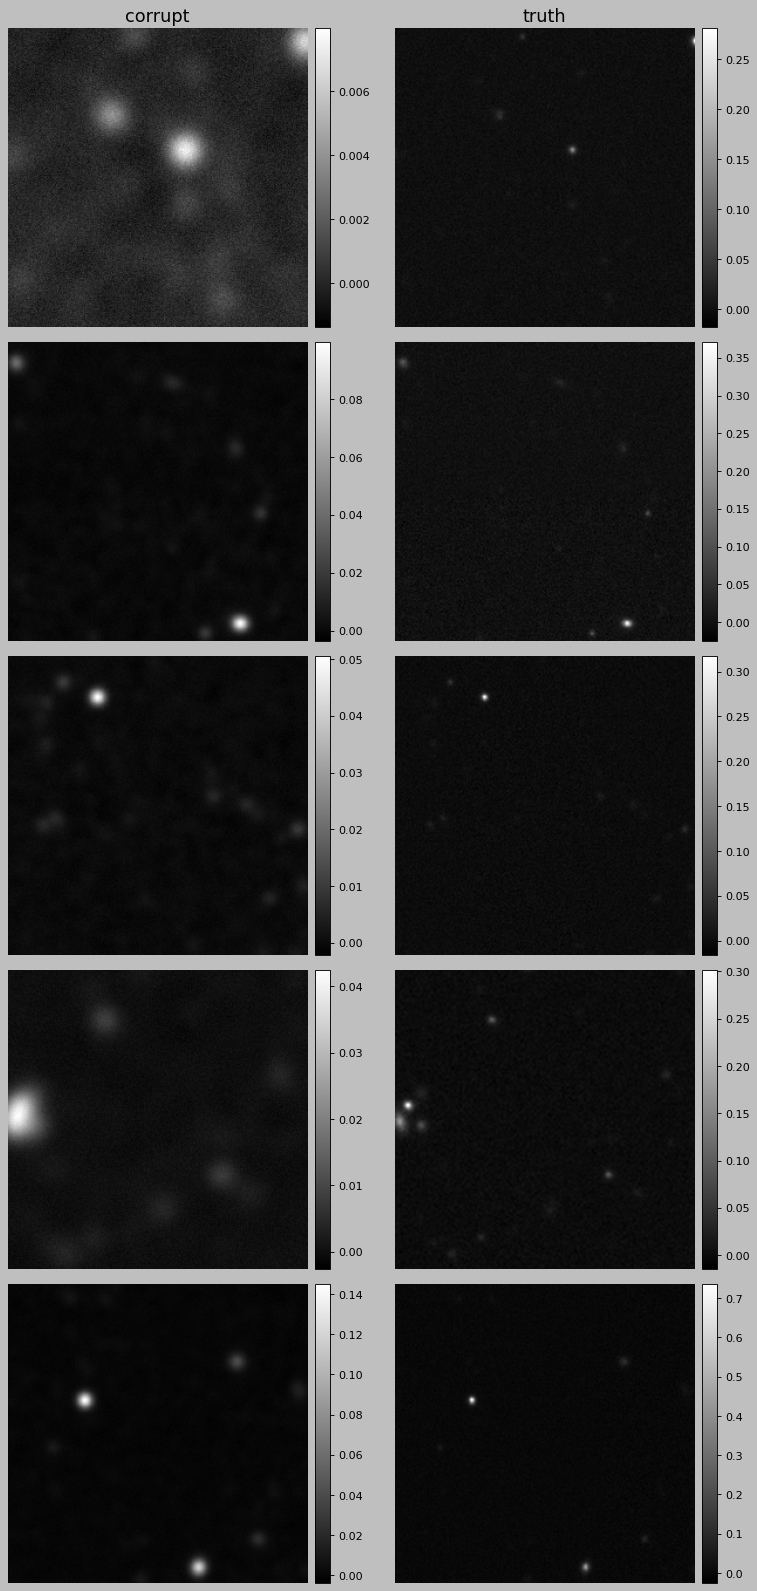

In [ ]:
fig, ax = plt.subplots(figsize=(10, size*4), nrows=size, ncols=2)

for i in range(size):
    if i == 0:
        titles = ["corrupt", "psf", "truth"]
    else:
        titles = [None]*3
    
    display(corrupt[i], ax=ax[i, 0], title=titles[0], axis=False, norm=None, cmap="gray")
    display(truth[i], ax=ax[i, 1], title=titles[2], axis=False, norm=None, cmap="gray")

plt.tight_layout()
plt.show()

### FFT deconvolution
You'll notice how unstable this is! This is because of divisions by very small numbers. Can you guess where and why this occurs?

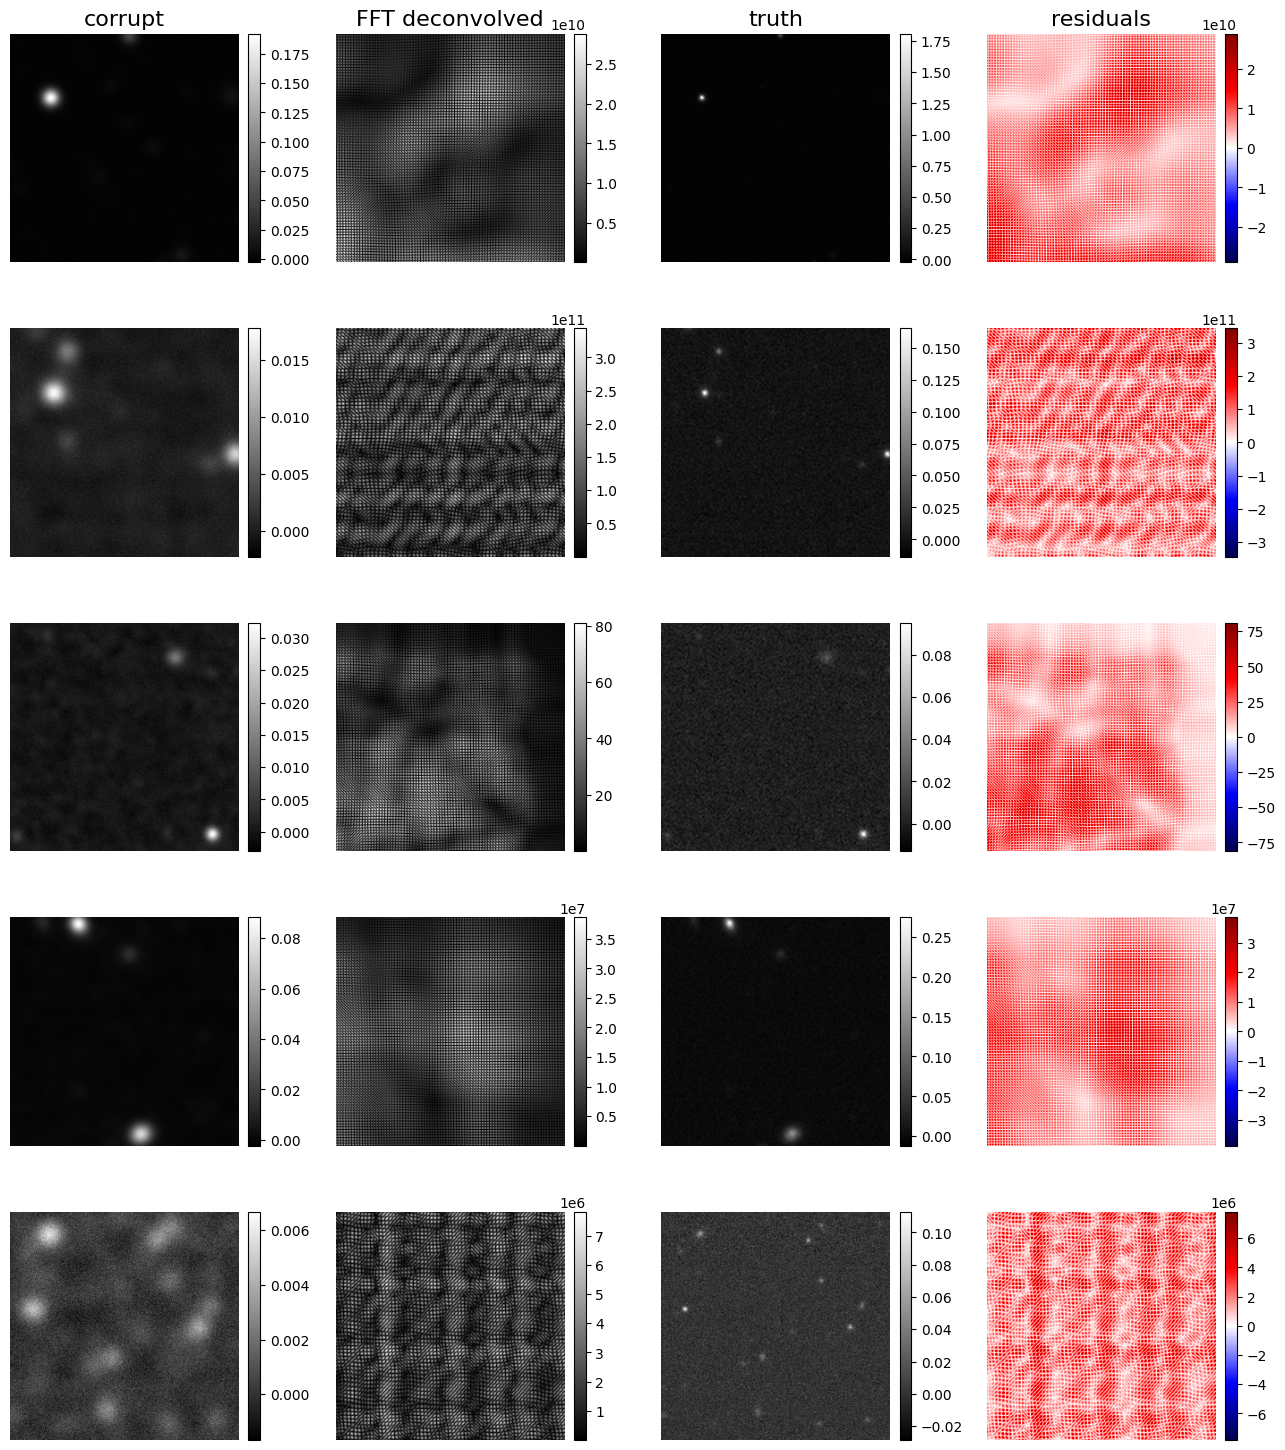

In [ ]:
deconvd_fft = np.empty_like(corrupt)

fig, ax = plt.subplots(figsize=(13, size*3), nrows=size, ncols=4)

for i in range(size):
    if i == 0:  
        titles = ["corrupt", "FFT deconvolved", "truth", "residuals"]
    else:
        titles = [None]*4

    deconvd_fft[i] = deconvolve_fft(corrupt[i], psf[i], pad_size=1000)
    
    display(corrupt[i], ax=ax[i, 0], title=titles[0], axis=False)
    display(deconvd_fft[i], ax=ax[i, 1], title=titles[1], axis=False)
    display(truth[i], ax=ax[i, 2], title=titles[2], axis=False)
    display(deconvd_fft[i] - truth[i], ax=ax[i, 3], title=titles[3], axis=False, cmap="seismic", norm="Centered")

plt.tight_layout()
plt.show()

## Lucy-Richardson deconvolution


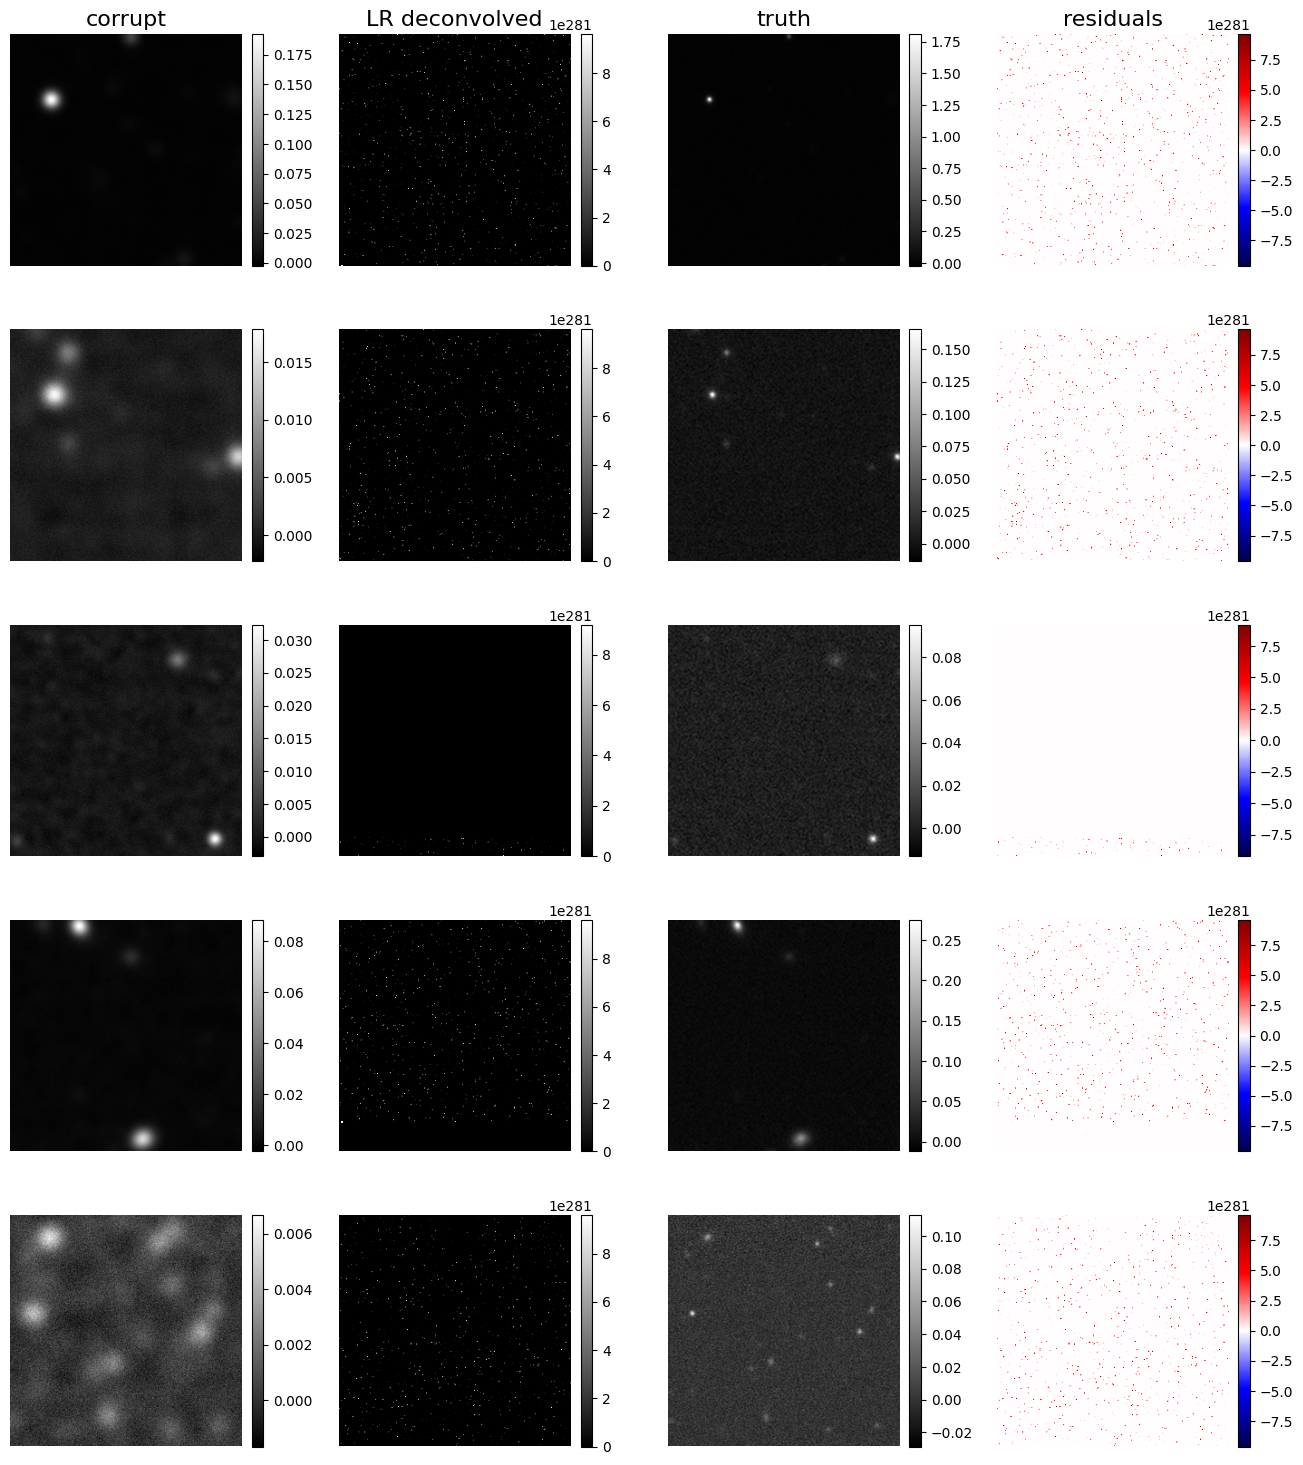

In [ ]:
deconvd_lr = np.empty_like(corrupt)

fig, ax = plt.subplots(figsize=(13, size*3), nrows=size, ncols=4)

for i in range(size):
    if i == 0:  
        titles = ["corrupt", "LR deconvolved", "truth", "residuals"]
    else:
        titles = [None]*4

    deconvd_fft[i] = deconvolve_lucyrichardson(corrupt[i] / np.abs(corrupt[i]).max(), psf[i] / psf[i].sum(), filter_epsilon=0.0001)
    
    display(corrupt[i], ax=ax[i, 0], title=titles[0], axis=False)
    display(deconvd_lr[i], ax=ax[i, 1], title=titles[1], axis=False)
    display(truth[i], ax=ax[i, 2], title=titles[2], axis=False)
    display(deconvd_lr[i] - truth[i], ax=ax[i, 3], title=titles[3], axis=False, cmap="seismic", norm="Centered")

plt.tight_layout()
plt.show()

# Datasets

In [ ]:
class PSFDataset(Dataset):
    """
    pyTorch Dataset for loading corrupt images and PSFs and their associated original images.
    """
    def __init__(self, dir_path):

        self.dir_path = dir_path
        self.file_list = sorted(glob(f"{self.dir_path}/*.h5"))

        # Only open one file to get descriptor
        with h5py.File(self.file_list[0], mode="r") as h5_file:
            desc = ast.literal_eval(h5_file["base"].attrs["dataset_descriptor"])
            self.set_size = desc["set_size"]
            self.npix = desc["npix"]
            self.psf_npix = desc["psf_npix"]
            self.rpf = desc["rpf"]

        self.psf_padw = self.npix//2 - (self.psf_npix+1)//2

    def __len__(self):
        return len(self.all_ids)

    def getbatch(self, batched_ids):
        """
        get batch of examples in a same file from dataset
        """
        sample_file = self.file_list[batched_ids[0] // self.rpf]

        element_ids = [a % self.rpf for a in batched_ids]

        with h5py.File(sample_file, mode="r") as h5_file:
            corrupt_arr = h5_file["base"]["corrupt"][element_ids]
            psf_arr = h5_file["base"]["psf"][element_ids]
            truth_arr = h5_file["base"]["truth"][element_ids]

        assert corrupt_arr.shape[-1] % 2 ==0 and truth_arr.shape[-1] % 2 == 0 and corrupt_arr.shape == truth_arr.shape
        assert psf_arr.shape[-1] % 2 != 0            # check that psf has odd # of pixels to a side

        # psf_padded = np.pad(psf_arr, ((self.psf_padw, self.psf_padw+1), (self.psf_padw, self.psf_padw+1)))

        corrupt_tensor = torch.tensor(corrupt_arr).reshape(-1, 1, self.npix, self.npix)
        psf_tensor = torch.tensor(psf_arr).reshape(-1, 1, self.psf_npix, self.psf_npix)
        truth_tensor = torch.tensor(truth_arr).reshape(-1, 1, self.npix, self.npix)

        return (corrupt_tensor.float(), psf_tensor.float()), truth_tensor.float()

# Neural Network architectures

In [ ]:
class Network(nn.Module):
    def __init__(self):
        super().__init__()
        # Make your architecture here

    def forward(self, x):
        # define the flow of operations here
        ...

# Training loop

In [ ]:
# EPOCHS = 10
# TRAIN_SPLIT = 0.8
# BATCH_SIZE = 10
# LR = 1e-4           # learning rate
# SIZE = None         # size of subset of training set to use, None for all examples


# dataset = PSFDataset(dir_path=baseline_dataset_name)

# if SIZE is not None: train_size = min(SIZE, dataset.set_size - dataset.rpf)
# else: train_size = dataset.set_size - dataset.rpf

# model = ...
# model = model.to(DEVICE, non_blocking=True)
# optimizer = torch.optim.Adam(model.parameters(), lr=LR)
# criterion = ...         # loss function

# for epoch in range(EPOCHS):
#     for phase in ["valid", "train"]:

#         # Don't touch this, risk of mixing training and validation examples
#         if phase == "train":
#             model.train(True)
#             id_start = 0
#             id_stop = train_size
#         elif phase == "valid":
#             model.train(False)
#             id_start = dataset.set_size - dataset.rpf
#             id_stop = dataset.set_size

#         running_loss = 0.

#         # loop over batches
#         for b in range(id_start, id_stop, BATCH_SIZE):
#             batched_ids = list(range(b, b + BATCH_SIZE))
            
#             x_pair, y = dataset.getbatch(batched_ids)

#             corrupt = x_pair[0].to(DEVICE, non_blocking=True)
#             psf = x_pair[1].to(DEVICE, non_blocking=True)
#             truth = y.to(DEVICE, non_blocking=True)

#             if phase == "train":
#                 optimizer.zero_grad()

#                 output = model(corrupt, psf)
#                 loss = criterion(output, truth)
#                 loss.backward()
                
#                 optimizer.step()
            
#             elif phase == "valid":
#                 with torch.no_grad():
#                     output = model(corrupt, psf)
#                     loss = criterion(output, truth)

#             running_loss += float(loss.detach())

#         # after all batches processed
#         epoch_loss = running_loss / ((id_stop - id_start) // BATCH_SIZE)